In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import umap

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D


# LRP imports
import innvestigate
import innvestigate.utils as iutils


import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"
datadir = "data/"
figures_dir = "data/figures/"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

np.random.seed(seed=42) 
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [2]:
# Helper Functions

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold as KFold
# keras.backend.clear_session()

def getKF(X,y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 ) #Default = 10

    for train_index, test_index in kf.split(X,y):
        yield train_index, test_index
        
######### Taken from sklearn #######
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=[8,8])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot

def get_split(features, labels):
    features = np.array(features)
    labels = np.array(labels)
    # The train set will have equal amounts of each target class
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(features, labels):
        X_train = features[train_index]
        y_train = labels[train_index]
        X_test = features[test_index]
        y_test = labels[test_index]
        
        yield X_train, y_train, X_test, y_test

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(12,6),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()


def remove_label(features, labels, label="MCI"):
    labels = pd.Series(fused_labels)
    non_samples = labels != label

    stripped_features = features[non_samples]
    stripped_labels = labels[non_samples]

    return stripped_features, stripped_labels

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class AttributeRemover(BaseEstimator, TransformerMixin):
    """
    Returns a copy of matrix with attributes removed
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return # Doesn't do anything
    
    def transform(self, X, y=None):
        return X.drop(columns=self.attribute_names)

class OverSampler(BaseEstimator, TransformerMixin):
    """
    Returns a copy of matrix with attributes removed
    """
    def __init__(self, random_state=42):
        self.smote = SMOTE(random_state=random_state)
    
    def fit(self, X, y=None):
        return None
    
    def transform(self, X, y=None):
        return self.smote.fit_resample(X,y)

class dfHotEncoder(BaseEstimator, TransformerMixin):
    """
    Builds a hot encoder froma pandas dataframe
    Since the function expects an array of "features" per sample,
    we reshape the values
    """
    def __init__(self, random_state=42):
        self.enc = OneHotEncoder(categories="auto", sparse=False)
        self.categories_ = None
        return None
    
    def fit(self, labels):
        self.enc.fit(labels.values.reshape(-1,1))
        self.categories_ = self.enc.categories_
        return self
    
    def transform(self, labels):
        return self.enc.transform(labels.values.reshape(-1,1))
    
# Not used
train_pipeline = Pipeline([
                    ("smote", OverSampler()),
                    ("normalizer", StandardScaler()) ])

In [4]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

'''
Returns orginal samples, labels and modded_samples,modded_labels
'''
def modded_iris():

    from sklearn import datasets

    iris = datasets.load_iris()

    features = pd.DataFrame(iris["data"])
    target = pd.Series(iris["target"])
    flower_names = iris["target_names"]
    feature_names = iris["feature_names"]
    print(features.info())

    ### Get the first 2 flower samples

    setosa = target == 0
    versicolor = target == 1
    samples = features[setosa | versicolor]
    labels = target[setosa | versicolor]
    class_size = sum(versicolor)

    versicolor_samples = features[versicolor]
    versicolor_labels = target[versicolor]
    setosa_samples = features[setosa]

    ### Splitting *versicolor* into two sub classes

    versicolor_samples.describe()

    ## Constructing different noise sources
    gauss_noise = np.random.normal(loc=1,scale=0.25, size=[class_size//2,2])
    gauss_noise[gauss_noise < 0] = 0
    unif_noise = np.random.uniform(low=0,high=1)
    constant = 1


    split_size = class_size//2

    # Positive to first two features

    B1 = versicolor_samples.iloc[:split_size,:2] + gauss_noise
    B1 = np.concatenate((B1, versicolor_samples.iloc[:split_size,2:]), axis=1)
    B1_labels = versicolor_labels.iloc[:split_size]

    # Negative to last two features
    # gauss_noise = np.random.normal(loc=0.1,scale=0.1, size=[class_size//2,2])
    # gauss_noise[gauss_noise < 0] = 0
    # unif_noise = np.random.uniform(low=0,high=1)

    # B2 = versicolor_samples.iloc[split_size:,2:] + gauss_noise
    # B2 = np.concatenate((versicolor_samples.iloc[split_size:,2:],B2), axis=1)

    B2 = versicolor_samples.iloc[split_size:,:2] - gauss_noise
    B2 = np.concatenate((B2,versicolor_samples.iloc[split_size:,2:]), axis=1)
    B2_labels = versicolor_labels.iloc[split_size:] + 1

    # Combining the two fake "subclasses"
    noisy_samples = np.concatenate((B1, B2), axis=0)


    modded_samples = np.concatenate((setosa_samples,noisy_samples))
    modded_labels = labels.copy()
    modded_labels[class_size + split_size:] += 1

    return samples,labels,modded_samples, modded_labels


'''
Returns 8 gaussian blobs surrounding one center blob

       labels: Only center vs other labels (0,1) 
modded_labels: The labels for all 9 classes
'''
def simulate_blobs(class_size = 200):
    centers = [2*(x,y) for x in range(-1,2) for y in range(-1,2)]
    n_samples = [class_size//(len(centers)-1)]*len(centers)
    n_samples[len(centers)//2] = class_size

    X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=2, cluster_std=0.1, shuffle=False, random_state=42)

    plt.close("Original Distribution")
    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    fig, ax = plt.subplots(num= "Original Distribution")
    colors = {0:'red', 1:'blue'}
    df.plot(ax=ax,kind="scatter", x='x', y='y',c="label", cmap= "Paired")
    # plt.colorbar()
    plt.show()
    
    original_labels = df["label"].copy()
    modded_samples = df[["x","y"]].copy()
    labels = df["label"].copy()
    labels[labels != 4] = 0
    labels[labels == 4] = 1
    return df, modded_samples,labels, original_labels

## Half the data will be split out as validation and 0.2 as the test set

In [5]:

def get_split_index(features, labels, test_size=0.2):
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, original_labels, training_labels):
    train_index, validation_index = get_split_index(features, original_labels, test_size=0.5)[0]
    
    X_valid, y_valid, y_valid_original = features.iloc[validation_index],  training_labels.iloc[validation_index], original_labels.iloc[validation_index]
    X_train, y_train, y_original = features.iloc[train_index], training_labels.iloc[train_index], original_labels.iloc[train_index]
     
    return X_train, y_train, y_original, X_valid, y_valid, y_valid_original

def get_train_test_val(features, original_labels, training_labels):
    
    X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(features,original_labels, training_labels)
   
    train_index, test_index = get_split_index(X, y_original)[0]
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    return X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original

### Train a DNN on the modified dataset

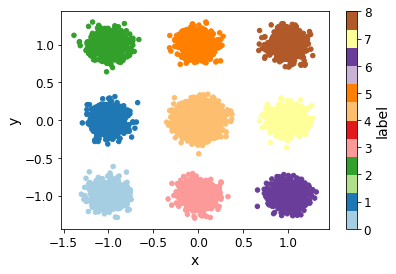

Train Size: (6000, 2)
Test Size: (6000,)
Categories: [array([0, 1])]


In [6]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=6000)

# Separating a hold out set that will be used for validation later
# X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)

X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(modded_samples, original_labels, training_labels)

print("Train Size:", X.shape)
print("Test Size:", y_valid.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [7]:

NUM_FEATURES = X.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [8]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
            kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [9]:
# nn = build_dnn(NUM_FEATURES)
# %time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=30, batch_size=20)

In [10]:
# Plotting results from history
# plot_history(history)

In [11]:
# preds = [x for x in nn.predict(Zscaler.transform(X_test[:5]))]
# _labels = [np.float(x) for x in y_test]
# preds[:5],_labels[:5]

In [12]:
def perform_lrp(model, samples, w_softmax = True):
    
    if w_softmax:
        model = iutils.keras.graph.model_wo_softmax(model)
    
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    
    return lrp_E.analyze(samples)

## Performing 10-Fold Cross Validation

In [22]:
from time import time

start_time = time()

histories = []
testing_indxs =[]
predictions = []
true_labels = []
cv_original_labels = []
cv_lrp_results = []
zoo = []

for train_index, test_index in getKF(X, y_original):
#     print(test_index)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    dnn = build_dnn(NUM_FEATURES, NUM_LABELS)
    history, ZScaler = train_model(dnn, X_train, y_train, X_test, y_test,
                                   verbose=0, plot=False, epochs=100, batch_size=20)

    # Updating all information arrays
    histories.append(history)
    testing_indxs.append(test_index)
    zoo.append((dnn, ZScaler))
    
    y_pred_probs = dnn.predict(ZScaler.transform(X_test))
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(hot_encoder.transform(y_test), axis=1)
    
    # Getting all the samples that can be correctly predicted
    correct = y_pred == y_true
    scaled_samples = ZScaler.transform(X_test)
    test_samples = scaled_samples[correct]
    lrp_samples = perform_lrp(dnn, test_samples)
    
    predictions.extend(y_pred)
    true_labels.extend(y_true)
    cv_original_labels.extend(y_original.iloc[test_index][correct])
    cv_lrp_results.extend(lrp_samples)
    
    print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(
        history.history["acc"][-1], history.history["val_acc"][-1]))
    
print("Runtime: {:.3f}s".format(time()-start_time))

Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Scores on test set: loss=1.000 accuracy=1.0000
Runtime: 198.856s


In [23]:
cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}

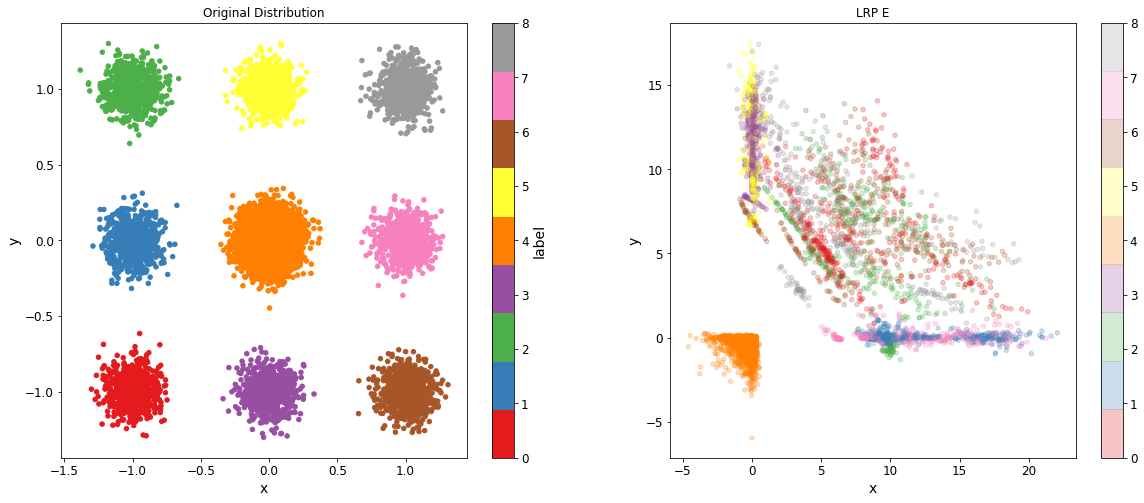

In [24]:
plt.close("CV LRP")
fig, axs = plt.subplots(1,2, figsize=(20,8), num="CV LRP")
_labels = cv_original_labels
lrp_df = DataFrame(cv_lrp_results,columns=["x","y"])

original_data.plot(ax=axs[0],kind="scatter", x='x', y='y',c="label", cmap= "Set1", title="Original Distribution")
lrp_df.plot(ax=axs[1],kind="scatter", x=0, y=1, c=_labels, cmap="Set1", s=20, alpha=0.25, title="LRP E")

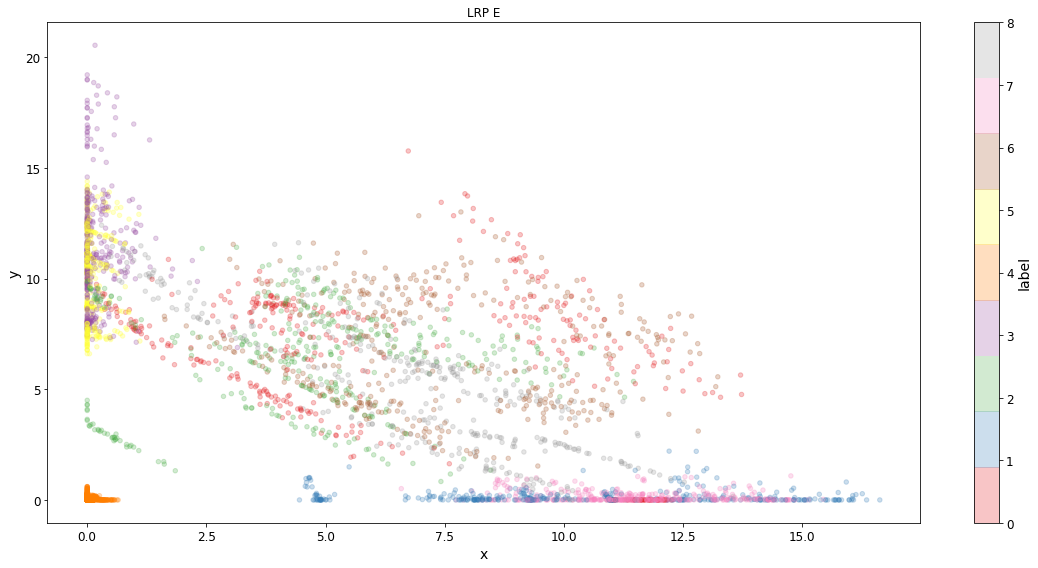

In [16]:
plt.close("Positve LRP")
fig, axs = plt.subplots(1,1, figsize=(16,8), num="Positive LRP")
plot_args["s"] = 20

pos_lrp = lrp_df.copy()
pos_lrp["label"] = cv_original_labels
pos_lrp[pos_lrp<0] = 0
pos_lrp.plot(ax=axs,title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

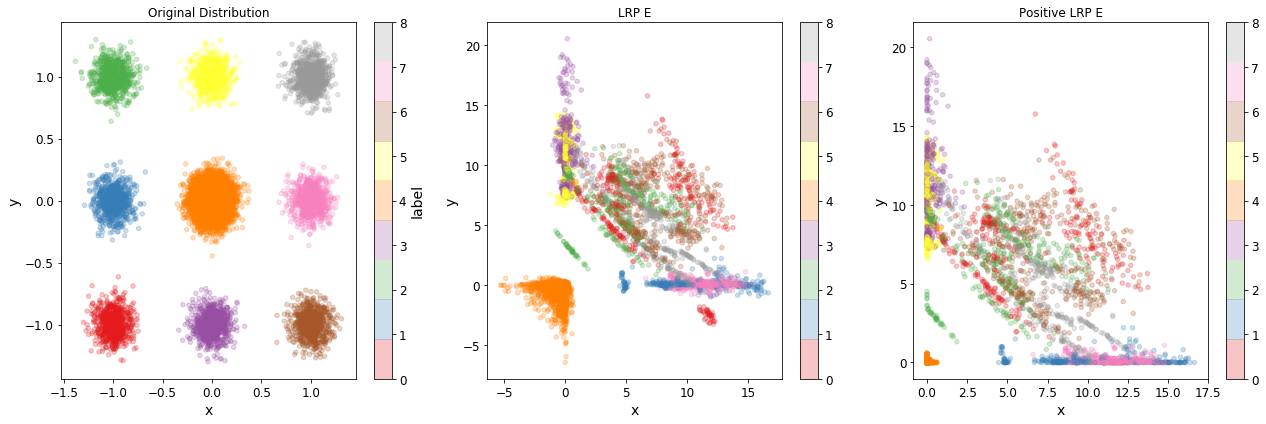

In [17]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
# plot_args["alpha"] = 0.5
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = cv_original_labels
lrp_df.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = lrp_df.copy()
pos_lrp[pos_lrp<0] = 0

pos_lrp["label"] = cv_original_labels
pos_lrp.plot(ax=axs[2],title="Positive LRP E", **plot_args)

plt.tight_layout()
plt.show()

In [18]:
# plt.savefig("../"+figures_dir+"deep_CV.png")

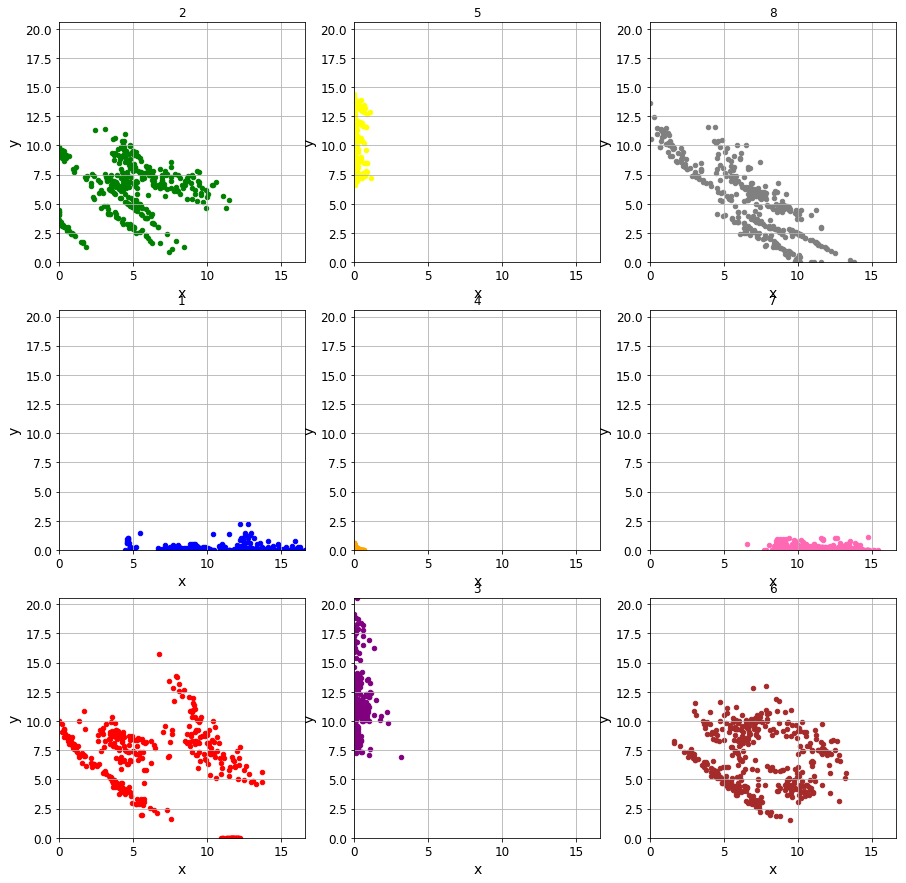

In [19]:
color_key = {0:"red",1:"blue", 2:"green", 3:"purple", 4: "orange", 5:"yellow", 6:"brown", 7:"hotpink", 8:"grey"}
grid_pos = {0:6, 1:3, 2:0, 3:7, 4:4, 5:1, 6:8, 7:5, 8:2}
x_min,y_min,_ = pos_lrp.min()
x_max,y_max,_ = pos_lrp.max()

plt.close("Class Level LRP")
fig, axs = plt.subplots(3,3, figsize=(15,15), num="Class Level LRP")
axs = axs.flatten()
grouped = pos_lrp.groupby(by="label")
for key,group in grouped:
    group.plot(ax=axs[grid_pos[key]],kind="scatter",x=0,y=1, title=key, color=color_key[key], xlim = (x_min,x_max), ylim=(y_min,y_max), grid=True)


In [20]:
# plt.savefig(figures_dir+"deep_CV_separated.png")

## Performing SVM on Modded Samples

In [21]:
from sklearn.svm import LinearSVC

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(C=1, loss="hinge", max_iter=5000 ))
])

%time svm_clf.fit(X_train, y_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_test, y_test)))

CPU times: user 19.8 ms, sys: 4.09 ms, total: 23.9 ms
Wall time: 8.11 ms
Linear SVM Test Accuracy: 0.690
